In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import xarray as xr
from tqdm.auto import tqdm

In [2]:
from icesea2.experiments import gen_lhs_from_dict, norm_to_values, topography_to_icesheet_nc, gen_margin_input_files, gen_run_configs
from icesea2.shearstress import make_shear_stress_map
from icesea2.margins import shp_series_to_icesheet
from icesea2.models import IcesheetModel
from icesea2.gridtools import grid_icesheet_pool, grid_icesheet_series
 

In [3]:
shear_stress_map_name = "ely_victor_eurasia"
shear_stress_map_file = "/nfs/annie/cm15ogp/phd/data/shear_stress/eurasia/regions.shp"

In [4]:
dx = 5000
dy = 5000
x_min = -1265453.0
x_max = 4159547.0
y_min = -4722734.8
y_max = 1352265.2
grid_x = np.arange(x_min, x_max+dx, dx)
grid_y = np.arange(y_min, y_max+dy, dy)

grid_crs = '+ellps=WGS84 +proj=laea +lon_0=0.0 +lat_0=90 +x_0=0.0 +y_0=0.0 +no_defs'

In [5]:
times = [-22000,-20000,-18000,-16000]

In [6]:
shear_stress_parameters_var_ranges = {
    "g_lgm_ice_streams_ice_stream": [5000,20000],
    "g_sediment_marine_sediment": [10000,30000],
    "g_sediment_onshore_sediment": [30000,100000],
    "g_sediment_bedrock": [100000,150000],
    "p_ice_stream_interior_dist": [0,1000],
    "p_cold_ice_shear_stress": [120000,200000],
    "p_cold_ice_interior_dist": [1000,300]
}
shear_stress_parameters_const = {
    "m_base_map_name": shear_stress_map_name,
    "m_base_map_file": shear_stress_map_file,
    "m_gauss_blur": 1,
    "m_base_value": 5000,
    "m_combine_pattern": "(g_sediment | (g_lgm_ice_streams * p_ice_stream)) | p_cold_ice",
    "g_layers": ["sediment", "lgm_ice_streams"],
    "p_processes": ["ice_stream", "cold_ice"],
}

In [7]:
ranges = np.array(list(shear_stress_parameters_var_ranges.values()))
min_vals, max_vals = ranges[:,0], ranges[:,1]

In [8]:
from itertools import product

def vertices(N): 
    return np.array(list(product((0, 1), repeat=N)))

corner_values = vertices(7) * (max_vals - min_vals) + min_vals

In [65]:
! pwd

/nfs/annie/cm15ogp/phd/paper1/paper1_data/icesheet_runs/glac1d/corners


In [64]:
exp_vars.to_csv("corners_sample.csv", index=False)

In [9]:
exp_vars = pd.DataFrame(corner_values, columns=list(shear_stress_parameters_var_ranges.keys()))
exp_vars

,g_lgm_ice_streams_ice_stream,g_sediment_marine_sediment,g_sediment_onshore_sediment,g_sediment_bedrock,p_ice_stream_interior_dist,p_cold_ice_shear_stress,p_cold_ice_interior_dist
0,5000,10000,30000,100000,0,120000,1000
1,5000,10000,30000,100000,0,120000,300
2,5000,10000,30000,100000,0,200000,1000
3,5000,10000,30000,100000,0,200000,300
4,5000,10000,30000,100000,1000,120000,1000
...,...,...,...,...,...,...,...
123,20000,30000,100000,150000,0,200000,300
124,20000,30000,100000,150000,1000,120000,1000
125,20000,30000,100000,150000,1000,120000,300
126,20000,30000,100000,150000,1000,200000,1000


In [57]:
! ls /nfs/annie/cm15ogp/phd/data/ice_margins/glac1d

generate_glac1d_margins.ipynb  raw_v1	  smooth_v1_topoclip_mod_-1km
plots			       smooth_v1


In [10]:
margins_name = "glac1d_smooth_v1_topoclip_mod_-1km"
margins_dir = "/nfs/annie/cm15ogp/phd/data/ice_margins/glac1d/smooth_v1_topoclip_mod_-1km"
run_dir = "/nfs/annie/cm15ogp/phd/paper1/paper1_data/icesheet_runs/glac1d/corners/"

t_var_topo = True
e_var_topo = False
e_var_ss = True
t_var_ss = True
e_var_margins = False

In [78]:
shear_stress_parameters = {'m_base_map_name': 'ely_victor_eurasia',
 'm_base_map_file': '/nfs/annie/cm15ogp/phd/data/shear_stress/eurasia/regions.shp',
 'm_gauss_blur': 0,
 'm_base_value': 5000,
 'm_combine_pattern': '(g_lgm_ice_streams * p_ice_stream)',
 'g_layers': ['sediment', 'lgm_ice_streams'],
 'p_processes': ['ice_stream', 'cold_ice'],
 'g_lgm_ice_streams_ice_stream': 20000,
 'g_sediment_marine_sediment': 30000,
 'g_sediment_onshore_sediment': 100000,
 'g_sediment_bedrock': 150000,
 'p_ice_stream_interior_dist': 0,
 'p_cold_ice_shear_stress': 200000,
 'p_cold_ice_interior_dist': 300,
 'p_margin_name': 'glac1d_smooth_v1_topoclip_mod_-1km',
 'p_margin_time': -16000,
 'p_margin_file': '/nfs/annie/cm15ogp/phd/data/ice_margins/glac1d/smooth_v1_topoclip_mod_-1km/-16000/margin.shp'}

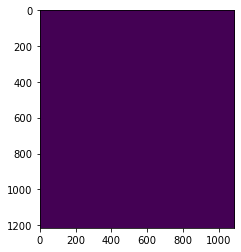

In [79]:
plt.imshow(make_shear_stress_map(
    grid_x = grid_x, 
    grid_y = grid_y, 
    grid_crs = grid_crs, 
    parameters = shear_stress_parameters
).raster, interpolation='none')

In [11]:
for time in tqdm(times):
    margin_filename = str(Path(margins_dir) / str(time) / "margin.shp")
    shear_stress_parameters_margins = {
        "p_margin_name": margins_name,
        "p_margin_time": time,
        "p_margin_file": margin_filename,
    }
    for exp_name, values in tqdm(exp_vars.iterrows(), total=len(exp_vars)):
        inputs_dir_shear_stress = (
            Path(run_dir) / 
            'inputs' / 
            'shearstress' / 
            str(time) / 
            str(exp_name)
        )
        inputs_dir_shear_stress.mkdir(exist_ok=True, parents=True)
        shear_stress_parameters_var = values.to_dict()
        shear_stress_parameters = {
            **shear_stress_parameters_const, 
            **shear_stress_parameters_var, 
            **shear_stress_parameters_margins,
        }

        make_shear_stress_map(
            grid_x = grid_x, 
            grid_y = grid_y, 
            grid_crs = grid_crs, 
            parameters = shear_stress_parameters,
            save=str(inputs_dir_shear_stress / "shearstress.nc")
        )


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

In [12]:
inputs_dir_margins = (
    Path(run_dir) / 
    'inputs' / 
    'margins'
)
inputs_dir_margins.mkdir(exist_ok=True, parents=True)

shp_series_to_icesheet(
    margins_dir, 
    grid_crs, 
    str(inputs_dir_margins), 
    times=times
)

In [16]:
topography_name = "glac1d_laea_5km_eurasia"
topography_nc = "/nfs/annie/cm15ogp/phd/data/ice_models/glac1d/glac1d_topo_laea_5km_eurasia.nc"


In [17]:
# topography
inputs_dir_topography = (Path(run_dir) / "inputs/topography")
inputs_dir_topography.mkdir(exist_ok=True, parents=True)
topography_to_icesheet_nc(topography_nc=topography_nc, output_dir=inputs_dir_topography, times=times)

In [18]:
t_var_topo = True
e_var_topo = False
e_var_ss = True
t_var_ss = True
t_var_margins = True
e_var_margins = False

In [59]:
run_configs = []
for member, config in exp_vars.iterrows():
    config = config.to_dict()
    run_config = gen_run_configs(
        run_dir = str(run_dir),
        times = times,
        member_name = str(member),
        t_var_topo=t_var_topo,
        e_var_topo=e_var_topo,
        t_var_ss=t_var_ss,
        e_var_ss=e_var_ss,
        e_var_margins=e_var_margins
    )
    run_configs = run_configs + run_config

In [61]:
ism = IcesheetModel("/nfs/annie/cm15ogp/code/icesheet/binaries/icesheet")

In [62]:
ism.run_pool(run_configs, cores=24)